# RFM - Customer Segmentation

Using the [online retail dataset](https://archive.ics.uci.edu/ml/datasets/Online+Retail) from the UCI Machine Learning Repository for exploratory data analysis and customer segmentation using RFM Analysis K-Means Clustering.

### Data Set Information:

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.



#### This notebook covers:

1. Data Cleaning

2. Cohort Analysis

3. Exploartory Data Analysis

4. RFM Analysis

5. K-Means Clustering


In [1]:
!pip3 install squarify

In [2]:
import pandas as pd
import numpy as np
import warnings

#visualizations
import seaborn as sns
import squarify as sq
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt

warnings.filterwarnings('ignore')

# 1. Data Cleaning

In [3]:
df = pd.read_excel("Online Retail.xlsx")

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Attribute Information:

**InvoiceNo**: Invoice number. **Nominal**, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
<br>
**StockCode**: Product (item) code. **Nominal**, a 5-digit integral number uniquely assigned to each distinct product.
<br>
**Description**: Product (item) name. **Nominal**. 
<br>
**Quantity**: The quantities of each product (item) per transaction. **Numeric**.
<br>
**InvoiceDate**: Invice Date and time. **Numeric**, the day and time when each transaction was generated.
<br>
**UnitPrice**: Unit price. **Numeric**, Product price per unit in sterling.
<br>
**CustomerID**: Customer number. **Nominal**, a 5-digit integral number uniquely assigned to each customer.
<br>
**Country**: Country name. **Nominal**, the name of the country where each customer resides.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Our dataset is composed of 8 columns and 541,909 rows. Let's explore the different columns and then check for null values and decide how we want to deal with them.

In [6]:
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ", df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique())
print('Number of countries: ', df['Country'].nunique())

Number of transactions:  25900
Number of products bought:  4070
Number of customers: 4372
Number of countries:  38


**Check for Null Values**

In [7]:
np.sum(df.isnull())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
print("Percentage of customers missing: ", round(df['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Percentage of customers missing:  24.93 %


- We are missing values in the CustomerID and Description columns.
<br>
- We will investigate the records where the CustomerID field is null to determine whether to erase those rows or fill in the missing values.
<br>
- Since we won't be doing analysis on the descriptions of the orders, we can leave the null values as is

In [9]:
df['CustomerID_is_null'] = [1 if i == True else 0 for i in df.CustomerID.isnull()]

In [10]:
#Create a new dateframe of only orders with missing CustomerID values
df1 = df[df['CustomerID_is_null'] == 1]

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135080 entries, 622 to 541540
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           135080 non-null  object        
 1   StockCode           135080 non-null  object        
 2   Description         133626 non-null  object        
 3   Quantity            135080 non-null  int64         
 4   InvoiceDate         135080 non-null  datetime64[ns]
 5   UnitPrice           135080 non-null  float64       
 6   CustomerID          0 non-null       float64       
 7   Country             135080 non-null  object        
 8   CustomerID_is_null  135080 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 10.3+ MB


In [12]:
df1.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,1
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,1
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,1
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,1
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom,1
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom,1
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom,1


In [13]:
print("Number of orders in df1:", df1['InvoiceNo'].nunique())
print("Avg. number of products per order in df1: ", round(df1['StockCode'].count() / df1['InvoiceNo'].nunique(),2) )
print("Avg. number of products per order in df: ",  round(df['StockCode'].count() / df['InvoiceNo'].nunique(),2) )

Number of orders in df1: 3710
Avg. number of products per order in df1:  36.41
Avg. number of products per order in df:  20.92


Since the customer ID's are missing, lets assume these orders were not made by the customers already in the data set because those customers already have ID's. 

We also don't want to assign these orders to those customers because this would alter the insights we draw from the data. 

Instead of dropping the null **CustomerID** values, let's assign those rows a unique customer ID per order. This will act as a new customer for each unique order. 
<br>
<br>
**How should we assign the new customer ID's?**
<br>
<br>
Using the values in the **InvoiceNo** column would be the most straightfoward approach. We will create a new customer ID column called **NewID** with the invoice numbers filling in for the missing values. Then we will add the number of unique orders in df1 and to number of unique values in **CustomerID** and see if it equals the number of unique values in **NewID**. This will check if any of the new values match the existing values in the column and make sure we didn't add more orders to an existing customer.

In [14]:
#df['NewID'] = df['CustomerID']
#df.loc[df['CustomerID_is_null'] == 1, ['NewID']] = df['InvoiceNo']

#drop CustomerID column since it isn't need anymore
#df = df.drop('CustomerID', 1)
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,0


In [15]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           541909 non-null  object        
 1   StockCode           541909 non-null  object        
 2   Description         540455 non-null  object        
 3   Quantity            541909 non-null  int64         
 4   InvoiceDate         541909 non-null  datetime64[ns]
 5   UnitPrice           541909 non-null  float64       
 6   CustomerID          406829 non-null  float64       
 7   Country             541909 non-null  object        
 8   CustomerID_is_null  541909 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 37.2+ MB


In [16]:
print("Number of Orders in df1:", df1['InvoiceNo'].nunique())
print("Number of customers:", df['CustomerID'].nunique())

Number of Orders in df1: 3710
Number of customers: 4372


Since both values equal 8082, we know all the different orders that didn't have a customer ID got assigned unique NewID.

# 2. Create Cohort & Conduct Cohort Analysis

Since, We will be performing Cohort Analysis based on Transaction records of Customers, we will be Dealing with Mainly:
- Invoice Data
- CustomerID
- Price
- and Quantity columns in this Analsyis.

The Following steps will performed to generate the Cohort Chart of Retention Rate :
- Month Extraction from InvioceDate column
- Assigning Cohort to Each Transaction
- Assigning Cohort Index to each transaction
- Calculating number of unique customers in each Group of (ChortDate,Index)
- Creating Cohort Table for Retention Rate
- Creating the Cohort Chart using the Cohort Table

The Detailed information about each step is given below:

## Step 1: Let's extract the Month of the Purchase
#### First we will create a function, which takes any date and returns the formatted date with day value as 1st of the same month and Year.

In [17]:
def get_month(x):
    
    datetime_object = dt.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    return dt.datetime(datetime_object.year, datetime_object.month, 1)



#### Now we will use the function created above to convert all the invoice dates into respective month date format.

In [18]:
data = df
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)
grouping = data.groupby('CustomerID')['InvoiceMonth']
data['CohortMonth'] = grouping.transform('min')
data[['InvoiceDate','InvoiceMonth']].head()

,InvoiceDate,InvoiceMonth
0,2010-12-01 08:26:00,2010-12-01
1,2010-12-01 08:26:00,2010-12-01
2,2010-12-01 08:26:00,2010-12-01
3,2010-12-01 08:26:00,2010-12-01
4,2010-12-01 08:26:00,2010-12-01


### Step 2: Calculating time offset in Months i.e. Cohort Index:
Calculating time offset for each transaction will allows us to report the metrics for each cohort in a comparable fashion.
First, we will create 4 variables that capture the integer value of years, months for Invoice and Cohort Date using the get_date_int() function given below:

In [19]:
def get_date_int(df, column):    
    year = df[column].dt.year   
    month = df[column].dt.month    
    day = df[column].dt.day
    return year, month, day

#### We will use this function to extract the integer values for Invoice as well as Cohort Date in 3 seperate series for each of the two columns¶

In [20]:
invoice_year, invoice_month, _ = get_date_int(data, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(data, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# Using the variables created above to calcualte the difference in days and storing them in cohort Index column
data['CohortIndex'] = years_diff * 12 + months_diff + 1

data[['CustomerID','InvoiceDate','InvoiceMonth', 'CohortMonth', 'CohortIndex']].head()

,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth,CohortIndex
0,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01,1.0
1,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01,1.0
2,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01,1.0
3,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01,1.0
4,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01,1.0


## Create 1st Cohort: User number & Retention Rate

First, We will group by our dataset with respect to CohortMonth and CohortIndex first

In [21]:
grouping = data.groupby(['CohortMonth', 'CohortIndex'])

# printing len of group by object
#len(grouping)

In [22]:
cohort_data = grouping['CustomerID'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',                                     
                                     columns='CohortIndex',                                    
                                     values='CustomerID')
first_cohort = average_quantity.round(1)
first_cohort

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,15519.5,15223.2,15363.0,15286.1,15336.1,15337.3,15417.2,15439.1,15556.6,15352.5,15410.4,15339.2,15462.3
2011-01-01,15073.5,15178.5,14901.2,15121.9,14951.2,14972.5,14890.9,14746.1,15396.4,15175.3,15399.5,15377.9,NaN
2011-02-01,15293.0,15000.9,15012.5,15316.0,15495.0,14870.9,14892.4,15231.7,15175.2,14953.1,15197.9,NaN,NaN
2011-03-01,15164.7,15400.0,15196.4,15257.3,15347.6,15216.3,15257.6,15130.1,15309.2,15349.1,NaN,NaN,NaN
2011-04-01,15253.2,15298.4,15461.1,15966.6,15551.7,15086.5,15260.0,15505.8,15237.0,NaN,NaN,NaN,NaN
2011-05-01,15103.1,15468.6,15480.0,15330.2,15308.9,15208.5,15161.7,14963.1,NaN,NaN,NaN,NaN,NaN
2011-06-01,15219.0,16008.4,14920.3,15180.8,15344.3,15245.6,15498.9,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,15047.0,14942.4,15343.7,15048.9,15622.7,15791.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,14980.3,14654.1,14473.4,14415.9,14366.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
cohort_sizes = first_cohort.iloc[:,0]
retention = first_cohort.divide(cohort_sizes, axis=0)
retention.round(3) * 100



CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,98.1,99.0,98.5,98.8,98.8,99.3,99.5,100.2,98.9,99.3,98.8,99.6
2011-01-01,100.0,100.7,98.9,100.3,99.2,99.3,98.8,97.8,102.1,100.7,102.2,102.0,NaN
2011-02-01,100.0,98.1,98.2,100.2,101.3,97.2,97.4,99.6,99.2,97.8,99.4,NaN,NaN
2011-03-01,100.0,101.6,100.2,100.6,101.2,100.3,100.6,99.8,101.0,101.2,NaN,NaN,NaN
2011-04-01,100.0,100.3,101.4,104.7,102.0,98.9,100.0,101.7,99.9,NaN,NaN,NaN,NaN
2011-05-01,100.0,102.4,102.5,101.5,101.4,100.7,100.4,99.1,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,105.2,98.0,99.7,100.8,100.2,101.8,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,99.3,102.0,100.0,103.8,104.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,97.8,96.6,96.2,95.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


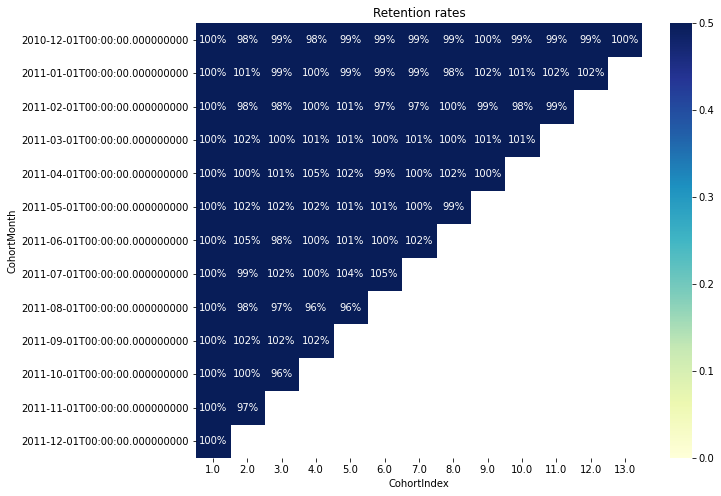

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.show()

## Create the 2nd Cohort: Average Quantity Sold

In [25]:
cohort_data2 = data.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity  = cohort_data2.pivot_table(index = 'CohortMonth',
                                            columns = 'CohortIndex',
                                       values = 'Quantity').round(1)
average_quantity

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


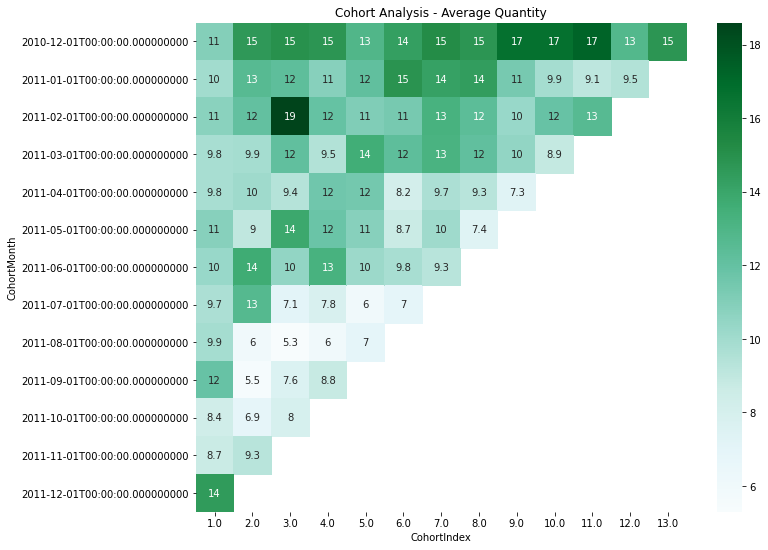

In [26]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Quantity')
sns.heatmap(data = average_quantity, 
            annot = True, 
            cmap = "BuGn")
plt.show()

## Create the 3rd Cohort: Average Sales


In [27]:
data['TotalSale'] = data['Quantity'] * data['UnitPrice']
cohort_data3 = data.groupby(['CohortMonth', 'CohortIndex'])['TotalSale'].mean().reset_index()
average_sales  = cohort_data3.pivot_table(index = 'CohortMonth',
                                           columns = 'CohortIndex',
                                      values = 'TotalSale').round(1)
average_sales

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,20.7,25.0,25.1,25.0,19.9,25.5,26.5,25.4,26.0,31.1,30.6,22.2,24.7
2011-01-01,18.4,23.5,20.3,17.5,21.5,25.4,24.4,24.5,18.7,20.1,18.7,18.4,NaN
2011-02-01,17.0,17.0,19.3,18.8,16.1,15.1,21.6,20.9,17.5,20.6,21.5,NaN,NaN
2011-03-01,17.0,17.9,21.5,17.0,19.2,18.1,21.7,17.3,15.4,11.4,NaN,NaN,NaN
2011-04-01,16.4,20.2,18.8,18.4,18.6,14.2,14.6,15.3,11.8,NaN,NaN,NaN,NaN
2011-05-01,19.0,15.7,21.2,19.4,17.8,14.1,16.1,13.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,16.4,14.5,19.0,19.8,15.0,15.9,12.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,13.1,21.2,11.4,12.4,10.5,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,16.1,11.9,11.5,14.4,15.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


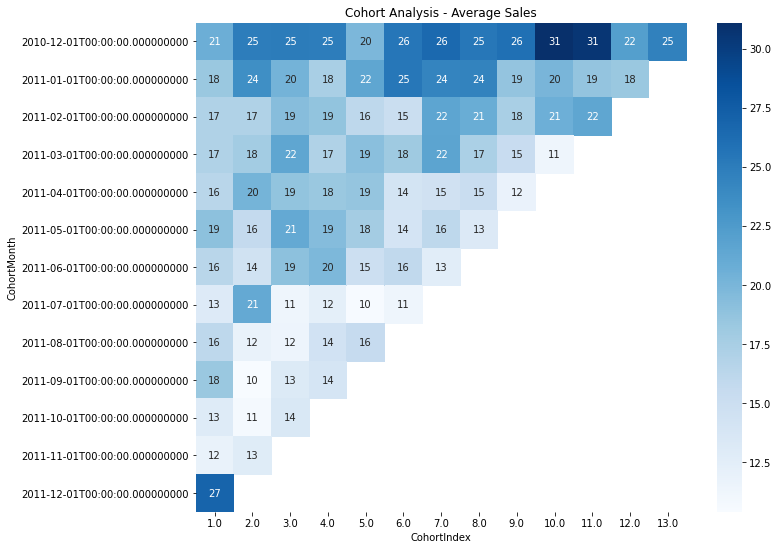

In [28]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Sales')
sns.heatmap(data = average_sales, 
            annot = True, 
            cmap = "Blues")
plt.show()

For e-commerce organisations, cohort analysis is a unique opportunity to find out which clients are the most valuable to their business.
by performing Cohort analysis you can get following answers to following questions:

- How much effective was a marketing campaign held in a particular time period.
- Did the strategy employed to improve the conversion rates of Customers worked?
- Should I focus more on retention rather than acquiring new customers?
- Are my customer nurturing strategies effective?
- Which marketing channels bring me the best results?
- Is there a seasoanlity pattern in Customer behahiour?
- along with varios perfromance measures/metrics for your organisation.

# 3. Exploratory Data Analysis

Now that our data set is clean, let's take a closer look at the numberic columns, specifically Quantity and UnitPrice.

In [29]:
df.describe()

,Quantity,UnitPrice,CustomerID,CustomerID_is_null,CohortIndex,TotalSale
count,541909.000000,541909.000000,406829.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,0.249267,5.185088,17.987795
std,218.081158,96.759853,1713.600303,0.432589,3.859473,378.810824
min,-80995.000000,-11062.060000,12346.000000,0.000000,1.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,0.000000,1.000000,3.400000
50%,3.000000,2.080000,15152.000000,0.000000,4.000000,9.750000
75%,10.000000,4.130000,16791.000000,0.000000,8.000000,17.400000
max,80995.000000,38970.000000,18287.000000,1.000000,13.000000,168469.600000


We see that there are negative values in the Quantity and UnitPrice columns. These are possibly canceled and returned orders. Let's check it out.

## Negative Values

If the invoice number starts with the letter "C", it means it the order was cancelled.

In [30]:
cancelled_orders = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,InvoiceMonth,CohortMonth,CohortIndex,TotalSale
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,-6.96


In [31]:
cancelled_orders[cancelled_orders['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,InvoiceMonth,CohortMonth,CohortIndex,TotalSale


When we filter canceled orders by Quantity> 0 nothing returns, this confirms that negative values mean the order was canceled.

**How many orders were cancelled?**

In [32]:
print("There were", len(cancelled_orders), "cancelled orders.")

#Calculate the percentage of cancellations by dividing the cancelled orders by the total orders
total_orders = df['InvoiceNo'].nunique()
number_cancelled = len(cancelled_orders)
print('Percentage of orders cancelled: {:.2f}% '.format(number_cancelled / total_orders * 100))

There were 9288 cancelled orders.
Percentage of orders cancelled: 35.86% 


9288 or about 36% of the orders were cancelled. Looking deeper into why these orders were cancelled may prevent future cancellations.

 Now let's find out what a negative UnitPrice means.

In [33]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,InvoiceMonth,CohortMonth,CohortIndex,TotalSale
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,1,2011-08-01,NaT,NaN,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,1,2011-08-01,NaT,NaN,-11062.06


The description of "Adjust bad debt" tells us that this is an adjustment for a customer with insufficient funds or an allowance for a customer who never paid for the order.

In [34]:
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]
df = df[pd.notnull(df['CustomerID'])]


In [35]:
df.describe()

,Quantity,UnitPrice,CustomerID,CustomerID_is_null,CohortIndex,TotalSale
count,397884.000000,397884.000000,397884.000000,397884.0,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453,0.0,5.179200,22.397000
std,179.331775,22.097877,1713.141560,0.0,3.861113,309.071041
min,1.000000,0.001000,12346.000000,0.0,1.000000,0.001000
25%,2.000000,1.250000,13969.000000,0.0,1.000000,4.680000
50%,6.000000,1.950000,15159.000000,0.0,4.000000,11.800000
75%,12.000000,3.750000,16795.000000,0.0,8.000000,19.800000
max,80995.000000,8142.750000,18287.000000,0.0,13.000000,168469.600000


## Exploring the Orders

#### a. What's the average number of orders per customer?

In [36]:
#Find the unique number of InvoiceNo  per customer
groupby_customers = pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].nunique())
groupby_customers.head()

,InvoiceNo
CustomerID,
12346.0,1
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [37]:
groupby_customers.describe()

,InvoiceNo
count,4338.000000
mean,4.272015
std,7.697998
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,209.000000


The average number of orders per customer is 3.
<br>
<br>
We found in descriptive statistics above that customers buy an average quantity of about 10 per product. Are there some products that are extremely popular? What's the distribution of the number of items the customers buy?

#### b. What's the average number of unqiue items per order and per customer?

In [38]:
groupby_invoice = pd.DataFrame(df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of Items per Order']
groupby_invoice.head()

,Number of Items per Order
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [39]:
groupby_invoice.describe()

,Number of Items per Order
count,18532.000000
mean,20.928178
std,23.816197
min,1.000000
25%,6.000000
50%,15.000000
75%,27.000000
max,541.000000


Let's see how this compares to the number of unique products per customer.

In [40]:

groupby_ID = pd.DataFrame(df.groupby('CustomerID')['StockCode'].nunique())
groupby_ID.columns = ['Number of Items per Customer']
groupby_ID.head()

,Number of Items per Customer
CustomerID,
12346.0,1
12347.0,103
12348.0,22
12349.0,73
12350.0,17


In [41]:
groupby_ID.describe()

,Number of Items per Customer
count,4338.000000
mean,61.501153
std,85.366768
min,1.000000
25%,16.000000
50%,35.000000
75%,77.000000
max,1787.000000


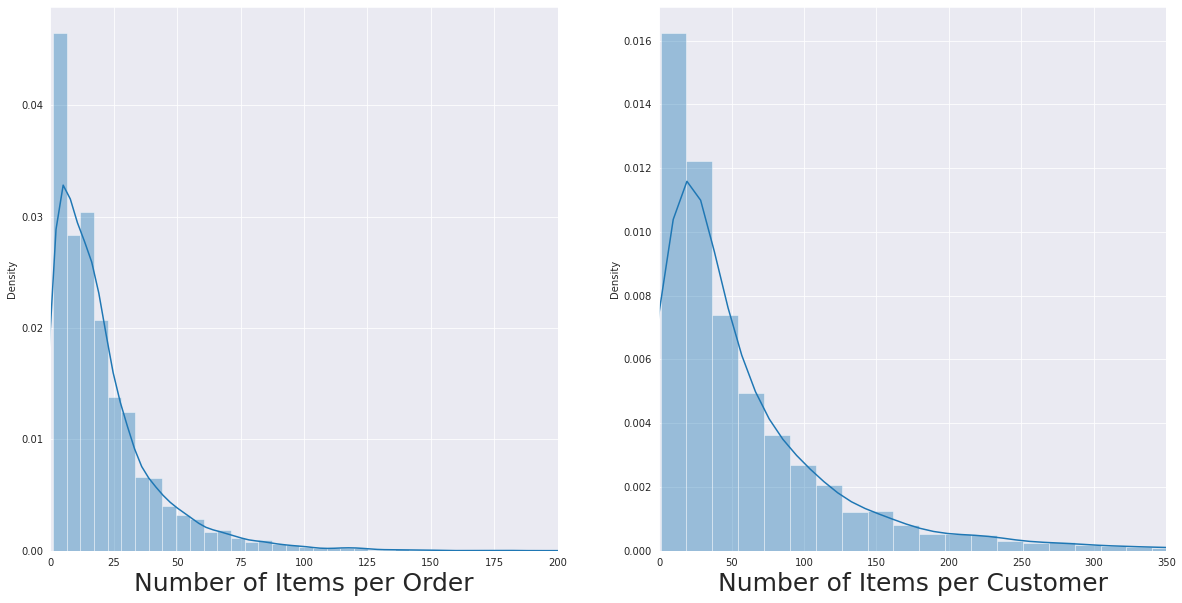

In [42]:
#Visualize the distribution of both
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)
plt1 = sns.distplot(groupby_invoice['Number of Items per Order'], ax=ax[0], bins=100)
plt1.set_xlim(0,200)
plt1.set_xlabel(xlabel='Number of Items per Order',fontsize=25)
plt2 = sns.distplot(groupby_ID['Number of Items per Customer'], ax=ax[1], bins=100)
plt2.set_xlim(0,350)
plt2.set_xlabel(xlabel='Number of Items per Customer',fontsize=25)
plt.show()

We have skewed left distributions for both plots. The average number of items per order is 20.5 and the average number of items per customer is 50.

## Customers by Country

In [43]:
df['Total_Cost'] = df['Quantity'] * df['UnitPrice']

In [44]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,InvoiceMonth,CohortMonth,CohortIndex,TotalSale,Total_Cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010-12-01,2010-12-01,1.0,20.34,20.34


** What's the total revenue per country? **

Let's look at the number of customers by country to get an idea of which countries have the most orders.

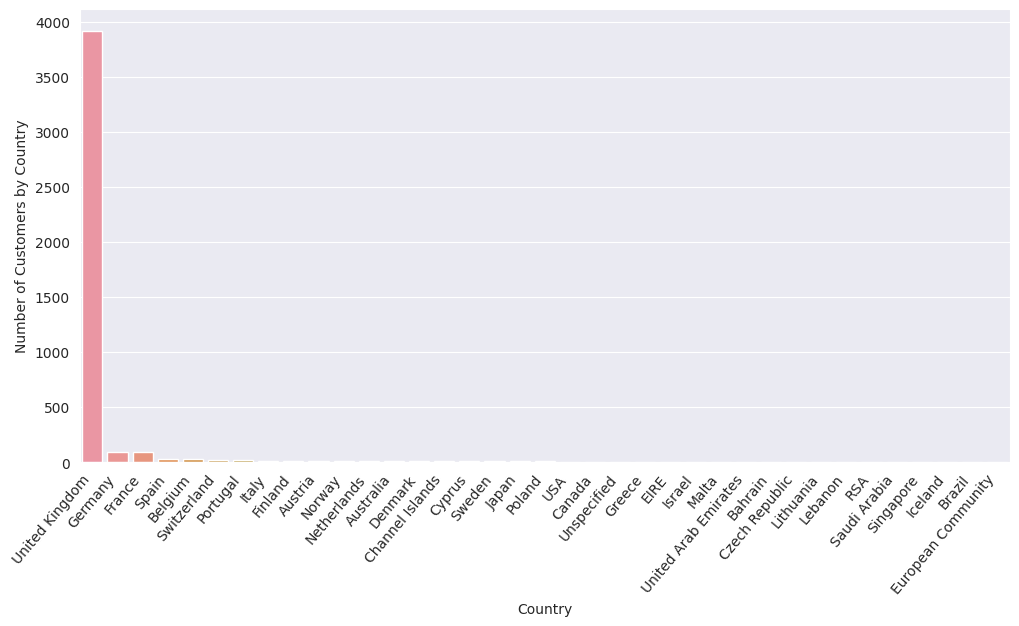

In [45]:
country_df = pd.DataFrame(df.groupby('Country')['CustomerID'].nunique())
country_df.columns = ['Number of Customers by Country']
country_df.sort_values('Number of Customers by Country', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(12,6),dpi=100)
ax=sns.barplot(x=country_df.index, y=country_df['Number of Customers by Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

The United Kingdom has significantly more customers than the other countries in our data set, so their total cost should look similar.

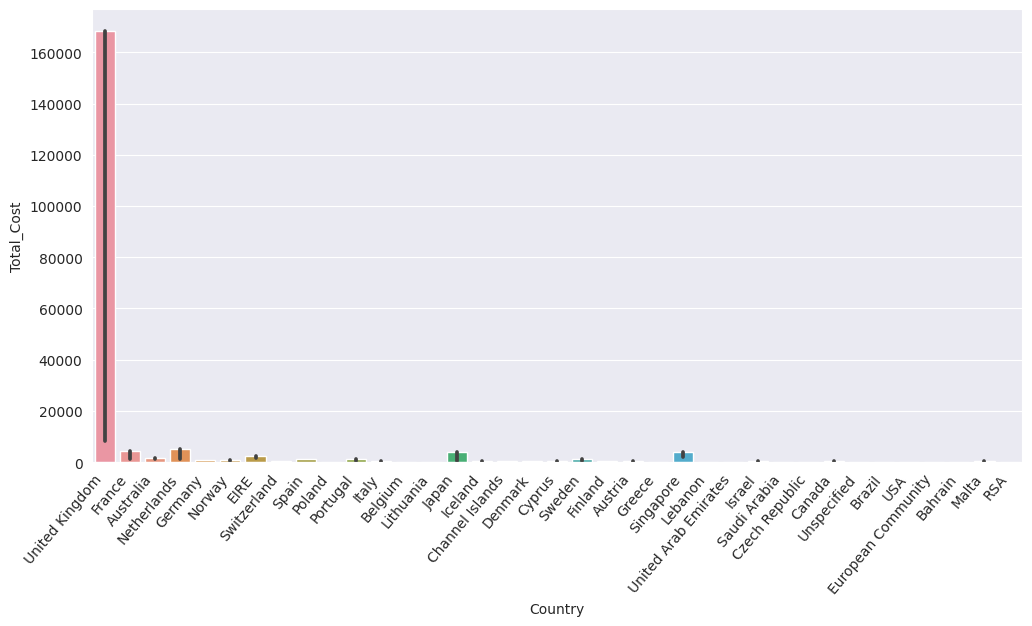

In [46]:
fig1, ax1 = plt.subplots(figsize=(12,6),dpi=100)
ax1=sns.barplot(x='Country', y='Total_Cost', data=df, estimator=max, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50, ha="right")
plt.show()

The UK not only has the most sales revenue, but also the most customers. Since the majority of this data set contains orders from the UK, we can explore the UK market further by finding out what products the customers buy together and any other buying behaviors to improve our sales and targeting strategy.

## Exploring the UK Market

In [47]:
df_uk = df[df['Country']=='United Kingdom']
df_uk.describe()

,Quantity,UnitPrice,CustomerID,CustomerID_is_null,CohortIndex,TotalSale,Total_Cost
count,354321.000000,354321.000000,354321.000000,354321.0,354321.000000,354321.000000,354321.000000
mean,12.013795,2.963994,15552.486392,0.0,5.157620,20.626470,20.626470
std,189.267956,17.862655,1594.527150,0.0,3.851542,326.044012,326.044012
min,1.000000,0.001000,12346.000000,0.0,1.000000,0.001000,0.001000
25%,2.000000,1.250000,14194.000000,0.0,1.000000,4.160000,4.160000
50%,4.000000,1.950000,15522.000000,0.0,4.000000,10.200000,10.200000
75%,12.000000,3.750000,16931.000000,0.0,8.000000,17.700000,17.700000
max,80995.000000,8142.750000,18287.000000,0.0,13.000000,168469.600000,168469.600000


In [48]:
print("Percentage of customers from the UK: ", round(df_uk['CustomerID'].nunique() * 100 / df['CustomerID'].nunique(),2),"%" )
print("Number of transactions: ", df_uk['InvoiceNo'].nunique())
print("Number of products Bought: ", df_uk['StockCode'].nunique())
print("Number of customers:", df_uk['CustomerID'].nunique())

Percentage of customers from the UK:  90.36 %
Number of transactions:  16646
Number of products Bought:  3645
Number of customers: 3920


**What are the most popular products that are bought in the UK?**

In [49]:
uk_product = df_uk.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
uk_product.head(10)

,StockCode,Description,Quantity
2514,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2016,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
2690,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49182
3548,85099B,JUMBO BAG RED RETROSPOT,41981
3555,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34648
2795,84879,ASSORTED COLOUR BIRD ORNAMENT,32727
1031,22197,POPCORN HOLDER,28935
1426,22616,PACK OF 12 LONDON TISSUES,24337
37,17003,BROCADE RING PURSE,22711
356,21212,PACK OF 72 RETROSPOT CAKE CASES,22465


We will continue analyzing the UK transactions with customer segmentation.

# 3. RFM Analysis

In the age of the internet and e-commerce, companies that do not expand their businesses online or utilize digital tools to reach their customers will run into issues like scalability and a lack of digital precsence. An important marketing strategy e-commerce businesses use for analyzing and predicting customer value is customer segmentation. Customer data is used to sort customers into group based on their behaviors and preferences.
<br>
<br>
Our goal in this Notebook is to cluster the customers in our data set to:
 - Recognize who are our most valuable customers
 - Increase revenue
 - Increase customer retention
 - Learn more about the trends and behaviors of our customers
 - Define customers that are at risk

We will start with **RFM Analysis** and then compliment our findings with predictive analysis using **K-Means Clustering Algorithms.**

- RECENCY (R): Time since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total monetary value
<br>
<br>
**RFM (Recency, Frequency, Monetary) Analysis** is a customer segmentation technique for analyzing customer value based on past buying behavior.
<br>
<br>

RFM analysis was first used by the direct mail industry more than four decades ago, yet it is still an effective way to optimize your marketing.

### Benefits of RFM Analysis

- Increased customer retention
- Increased response rate
- Increased conversion rate
- Increased revenue

It answers the following questions:
 - Who are our best customers?
 - Who has the potential to be converted into more profitable customers?
 - Which customers do we need to retain?
 - Which group of customers is most likely to respond to our marketing campaign?
 
Read more about RFM Analysis [here](https://www.putler.com/rfm-analysis/).

## Import Libraries

In [50]:
import time
import datetime as dt
from pandas.plotting import scatter_matrix

#Predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score

## Preparing the Data

In [51]:
#Check the shape of the data set
df_uk.shape

(354321, 14)

Let's remove the cancelled orders so the negative values don't affect our analysis.

In [52]:
df_uk = df_uk[df_uk['Quantity']>0]
df_uk.shape

(354321, 14)

Even though we went through the trouble of creating a new column for customer ID's without any null values, these fake customer ID's would skew our analysis, especially looking at frequency. Because all these "customers" only transacted with us onece, it would affect the ranking of real customers that transacted with us multiple times.

In [53]:
#remove rows where customerID are NA
df_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
df_uk.shape

(354321, 14)

In [54]:
print("Number of transactions: ", df_uk['InvoiceNo'].nunique())
print("Number of products bought: ",df_uk['StockCode'].nunique())
print("Number of customers:", df_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(df_uk['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Number of transactions:  16646
Number of products bought:  3645
Number of customers: 3920
Percentage of customers NA:  0.0 %


## a. Recency: Days since last purchase

To calculate recency, we need to choose a date as a point of reference to evaluate how many days ago was the customer's last purchase.

In [55]:
df_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

The most recent date is 12/9/2011 so we will use it as the reference.

In [56]:
now = dt.date(2011,12,9)

In [57]:
#Create a new column called Date which contains the invoice date without the timestamp
df_uk['Date'] = df_uk['InvoiceDate'].dt.date

In [58]:
#Group by NewID and check the last date of purchase
df_recency = df_uk.groupby(by='CustomerID', as_index=False)['Date'].max()
df_recency.columns = ['CustomerID', 'Last_Purchase_Date']
df_recency.head()

,CustomerID,Last_Purchase_Date
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [59]:
#Calculate the days since last purchase
df_recency['Recency'] = df_recency['Last_Purchase_Date'].apply(lambda x: (now - x).days)
df_recency.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [60]:
#Drop Last_Purchase_Date since we don't need it anymore
df_recency.drop('Last_Purchase_Date', axis=1, inplace=True)

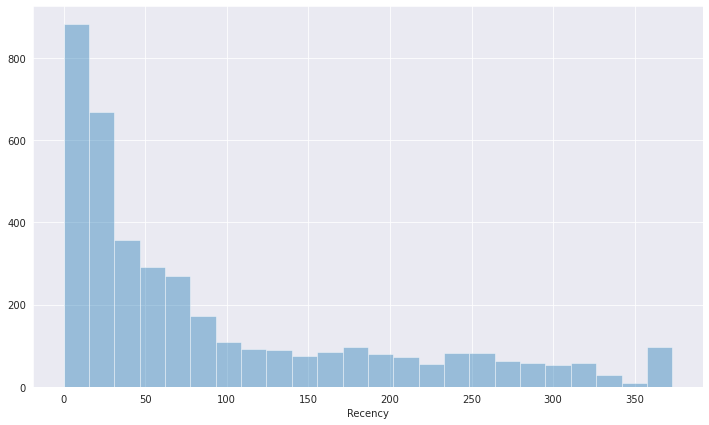

In [61]:
# Plot RFM distributions
plt.figure(figsize=(12,7))
# Plot distribution of R
sns.distplot(df_recency.Recency, kde=False)

Here, we can note that the histogram is biased towards the left side and hence this is a sign of distribution which is a right-skewed distribution. Based on that we can see that we have a high concentration of customers in the last 100 days, i.e. the last 4 months.

## b. Frequency: Number of purchases

To calculate how many times a customer purchased something, we need to count how many invoices each customer has.

In [62]:
#Make a copy of df_uk and drop duplicates
df_uk_copy = df_uk
df_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

#Calculate the frequency of purchases
df_frequency = df_uk_copy.groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()
df_frequency.columns = ['CustomerID','Frequency']
df_frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,209
3,12749.0,5
4,12820.0,4


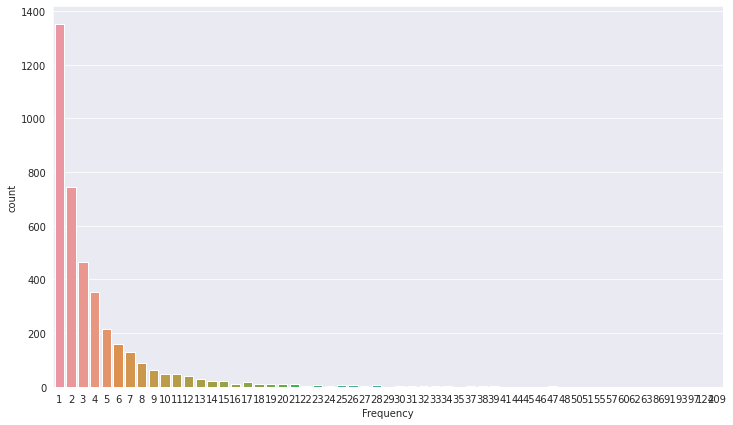

In [63]:
# Plot RFM distributions
plt.figure(figsize=(12,7))
# Plot distribution of F
sns.countplot(df_frequency.Frequency)

We can see that the majority of customers do not buy more than 4 times.

## c. Monetary: Total amount of money spent

The monetary value is calculated by adding together the cost of the customers' purchases. We already did this when we created the column **Total_Cost**

In [64]:
df_monetary = df_uk.groupby(by='CustomerID',as_index=False).agg({'Total_Cost': 'sum'})
df_monetary.columns = ['CustomerID', 'Monetary']
df_monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,689.49
2,12748.0,3841.31
3,12749.0,98.35
4,12820.0,58.20


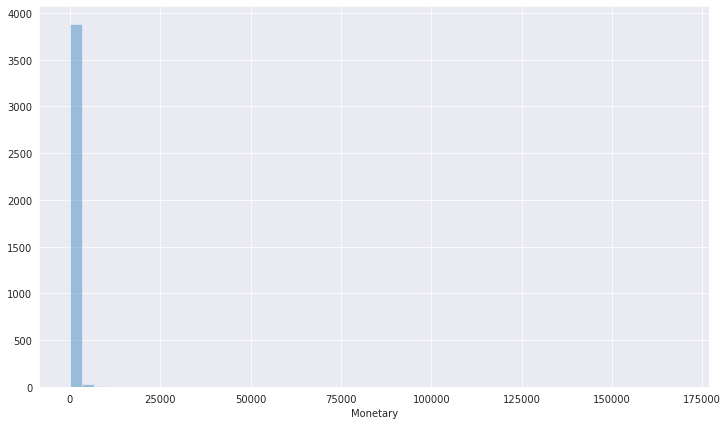

In [65]:
# Plot RFM distributions
plt.figure(figsize=(12,7))
# Plot distribution of R
sns.distplot(df_monetary.Monetary, kde=False)

## Create RFM Table

In [66]:
#Merge the recency and frequency dataframes
df_merge = df_recency.merge(df_frequency, on='CustomerID')
df_merge.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,11
2,12748.0,0,209
3,12749.0,3,5
4,12820.0,3,4


In [67]:
#Merge with monetary dataframe
df_rfm = df_merge.merge(df_monetary,on='CustomerID')
df_rfm.set_index('CustomerID',inplace=True)
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,689.49
12748.0,0,209,3841.31
12749.0,3,5,98.35
12820.0,3,4,58.20


If we look at CustomerID: 123460, his or her last purchase was 325 days ago (from reference date), they only bought from us one time, and they spent a total of $77,183.60

## Customer Segmentation with RFM Model

### RFM Scoring

The simplest way to create customer segments from an RFM model is by using **Quartiles**. We will assign a score from 1 to 4 to each category (Recency, Frequency, and Monetary) with 4 being the highest/best value. The final RFM score is calculated by combining the individual RFM values. 
<br>
<br>
**Note**: Data can be assigned into more groups for better granularity, but we will use 4 in this case

In [68]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,17.7000
0.50,50.0,2.0,45.4000
0.75,142.0,5.0,124.5375


In [69]:
quantiles.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.700000000000003,
  0.5: 45.400000000000006,
  0.75: 124.53750000000002},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0}}

**Creating the RFM Segmentation Table**

We will create two segmentation classes since high recency (more days since last purchase) is bad, while high frequency and montary value is good.

In [70]:
#Arguments (x= value, p = recency, monetary_value, frequency, d = quartiles dict)
def Rscore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#Arguments (x= value, p = recency, monetary_value, frequency, d = quartiles dict)
def FMscore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [71]:
#Create RFM segmentation table
rfm_segmentation = df_rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(Rscore, args=('Recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMscore, args=('Frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMscore, args=('Monetary',quantiles))

In [72]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12747.0,2,11,689.49,4,4,4
12748.0,0,209,3841.31,4,4,4
12749.0,3,5,98.35,4,3,3
12820.0,3,4,58.20,4,3,3


Now that we scored each customer, we'll combine the scores for segmentation.

In [73]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,4,114
12747.0,2,11,689.49,4,4,4,444
12748.0,0,209,3841.31,4,4,4,444
12749.0,3,5,98.35,4,3,3,433
12820.0,3,4,58.20,4,3,3,433


A score of 4 represents the customer being in the 75th percentile for that category. Let's see who are our best customers.

In [74]:
rfm_segmentation[rfm_segmentation['RFM_Score']=='444'].head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,
12747.0,2,11,689.49,4,4,4,444
12748.0,0,209,3841.31,4,4,4,444
12828.0,2,6,154.80,4,4,4,444
12839.0,2,14,233.91,4,4,4,444
12841.0,4,25,328.74,4,4,4,444
12877.0,3,12,365.79,4,4,4,444
12901.0,8,28,9230.45,4,4,4,444
12919.0,8,6,267.40,4,4,4,444
12921.0,9,37,1014.11,4,4,4,444


In [97]:
# Define rfm_level function
def rfm_level(df):
    
    if df['RFM_Score'] == "444":
        return 'Best Customers'
    elif ((df['F_Quartile'] == 4)):
        return 'Loyal Customers'
    elif ((df['M_Quartile'] == 4)):
        return 'Big Spenders'
    elif ((df['RFM_Score'] == '244')):
        return 'Almost Lost'
    elif ((df['RFM_Score'] == '144')):
        return 'Lost Customers'
    elif ((df['RFM_Score'] == '111')):
        return 'Lost Cheap Customers'
# Create a new variable RFM_Level
rfm_segmentation['RFM_Level'] = rfm_segmentation.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,4,114,Big Spenders
12747.0,2,11,689.49,4,4,4,444,Best Customers
12748.0,0,209,3841.31,4,4,4,444,Best Customers
12749.0,3,5,98.35,4,3,3,433,None
12820.0,3,4,58.20,4,3,3,433,None


In [76]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_segmentation.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                     Recency Frequency Monetary      
                        mean      mean     mean count
RFM_Level                                            
Almost Lost             78.2       8.2    588.2    65
Best Customers           6.7      16.8   1237.9   370
Lost Cheap Customers   261.1       1.0     10.5   377
Lost Customers         208.5      11.1    634.0    11


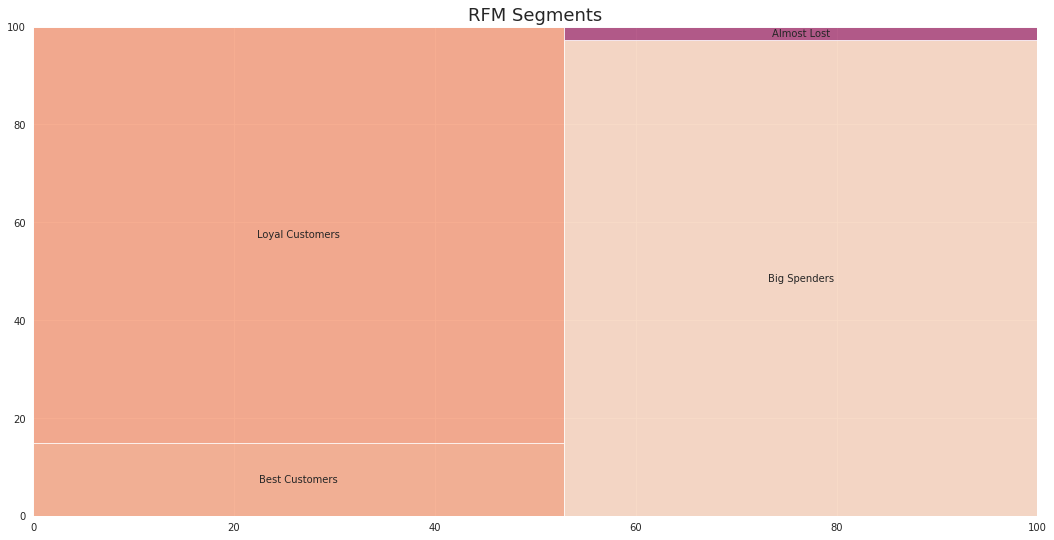

In [77]:
#pie chart, count plots

rfm_level_agg.columns = ['recency','frequency','monetary', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(18, 9)
sq.plot(sizes=rfm_level_agg['Count'], 
              label=['Best Customers',
                     'Loyal Customers',
                     'Big Spenders',
                     'Almost Lost',
                     'Lost Customers', 
                     'Lost Cheap Customers', 
                     'Require Activation'], alpha=.7 )
plt.title("RFM Segments",fontsize=18,fontweight="light")
plt.axis('on')
plt.show()

Using customer segmentation categories found [here](http://www.blastam.com/blog/rfm-analysis-boosts-sales) we can formulate different marketing strategies and approaches for customer engagement for each type of customer.

Note: The author in the article scores 1 as the highest and 4 as the lowest

**How many customers do we have in each segment?**

In [78]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_Score']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFM_Score']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='111']))

Best Customers:  370
Loyal Customers:  791
Big Spenders:  980
Almost Lost:  65
Lost Customers:  11
Lost Cheap Customers:  377


Now we can filter our dataset by each category and target each group differently.
<br>
<br>
For Example:
<br>
<br>
We could reward our **Best Customers** and **Loyal Customers** or create a "Refer a Friend" promotional offer targeted for them.
<br>
<br>
For the **Almost Lost** customers, we could aggressively market towards them with great deals so we don't lose them forever.

### Choosing a Predictive Model

Now that we have our customers segmented into 6 different categories, we can gain further insight into customer behavior by using predictive models in conjuction with out RFM model.
<br>
<br>
Possible algorithms include **Logistic Regression**, **K-means Clustering**, and **K-nearest Neighbor**. We will go with K-means since we already have our distinct groups determined. K-means has also been widely used for market segmentation and has the advantage of being simple to implement.

## Applying K-Means Clustering on RFM Variables

In [79]:
rfm_data = df_rfm.drop(['R_Quartile','F_Quartile','M_Quartile','RFM_Score'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary,RFM_Level
CustomerID,,,,
12346.0,325,1,77183.60,None
12747.0,2,11,689.49,Best Customers
12748.0,0,209,3841.31,Best Customers
12749.0,3,5,98.35,None
12820.0,3,4,58.20,None


### Feature Correlations

In [80]:
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.274142,-0.030145
Frequency,-0.274142,1.000000,0.163375
Monetary,-0.030145,0.163375,1.000000


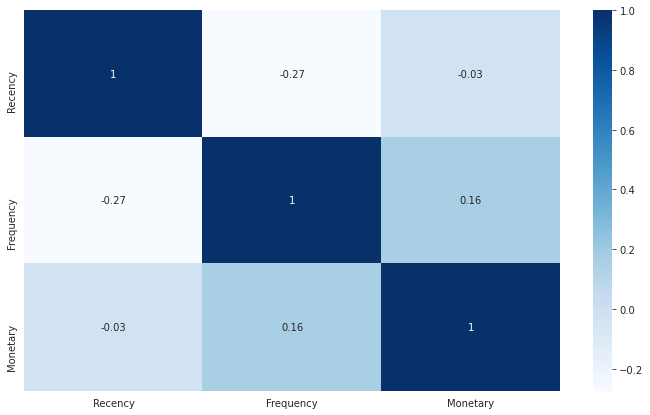

In [81]:
# Plot RFM distributions
plt.figure(figsize=(12,7))
sns.heatmap(rfm_data.corr(),cmap="Blues",annot=True)

Looking at this heatmap, we see that there is a negative correlation between Recency : Frequency and Recency : Monetary, but there is a positive correlation between Frequency : Monetary

### Visualizing Feature Distributions

To get a better understanding of the dataset, we can costruct a scatter matrix of each of the three features in the RFM data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f489967fcc0>,
      dtype=object)

<Figure size 864x504 with 0 Axes>

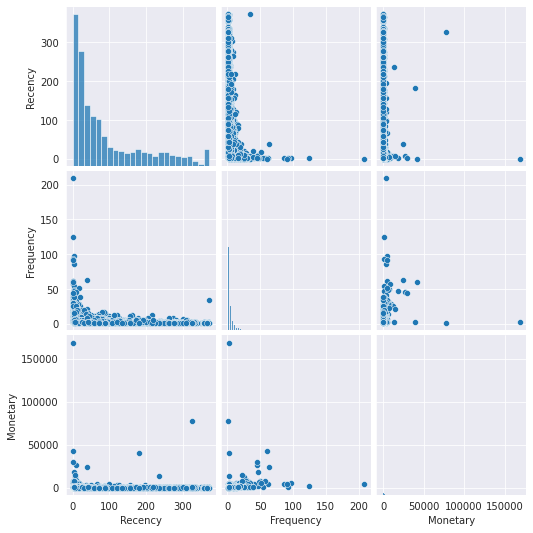

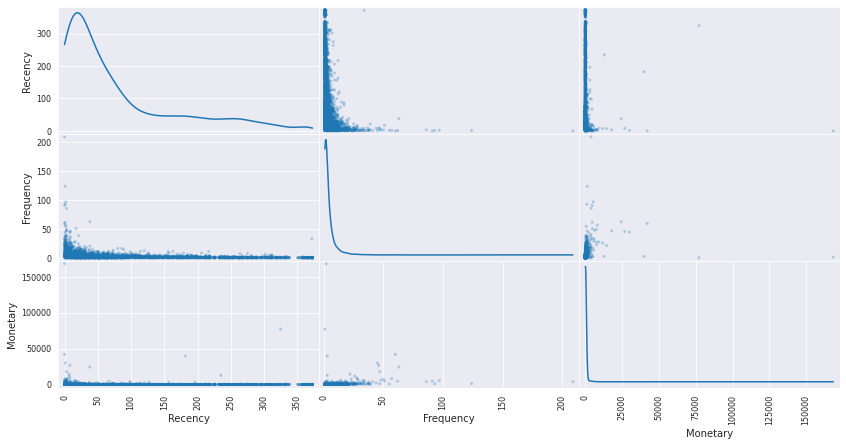

In [82]:
plt.figure(figsize=(12,7))
sns.pairplot(rfm_data)
scatter_matrix(rfm_data, alpha = 0.3, figsize = (14,7), diagonal = 'kde')

### Data Normalization

In [83]:
rfm_r_log = np.log(rfm_data['Recency']+0.1) #log(0) is undefined
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [84]:
log_data = pd.DataFrame({'Recency': rfm_r_log, 'Frequency': rfm_f_log,'Monetary': rfm_m_log})

In [85]:
log_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.784133,0.000000,11.253944
12747.0,0.741937,2.397895,6.536097
12748.0,-2.302585,5.342334,8.253595
12749.0,1.131402,1.609438,4.589549
12820.0,1.131402,1.386294,4.065602


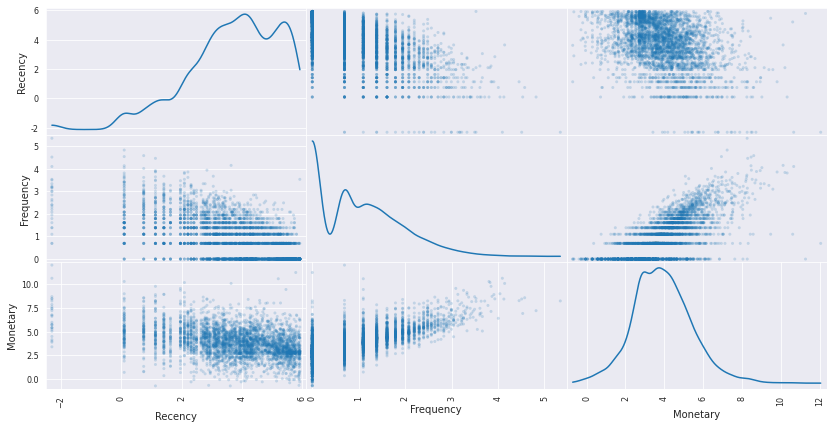

In [86]:
scatter_matrix(log_data, alpha = 0.2, figsize = (14,7), diagonal = 'kde');

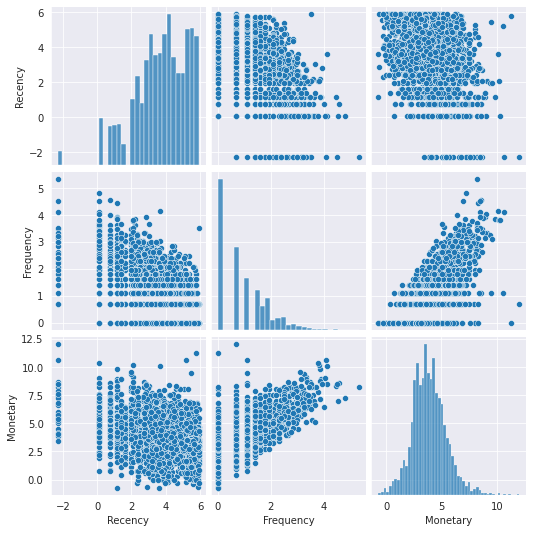

In [87]:
sns.pairplot(log_data)

The distributions of Monetary and Recency are more normailized, but recency is skewed to the left. Frequency was also skewed right because of a lot of customers only buying from us once.

In [88]:
log_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.574345,-0.370013
Frequency,-0.574345,1.000000,0.717461
Monetary,-0.370013,0.717461,1.000000


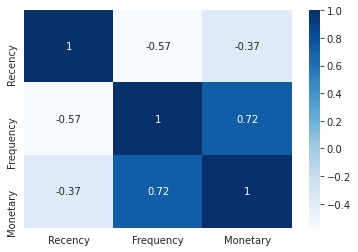

In [89]:
sns.heatmap(log_data.corr(),cmap="Blues",annot=True)

Now, Monetary and Frequency are more strongly correlated, so we will use those two variables in our K-Means model.

### K-Means Implementation

For k-means, you have to set k to the number of clusters you want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). 
<br>
<br>
**Note**: K-means is sensitive to initializations because they are critical to qualifty of optima found. Thus, we will use smart initialization called 

**Elbow Method**

In [90]:
import pickle

matrix = log_data.values
    
distortions = []

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(matrix)
    distortions.append(kmeanModel.inertia_)

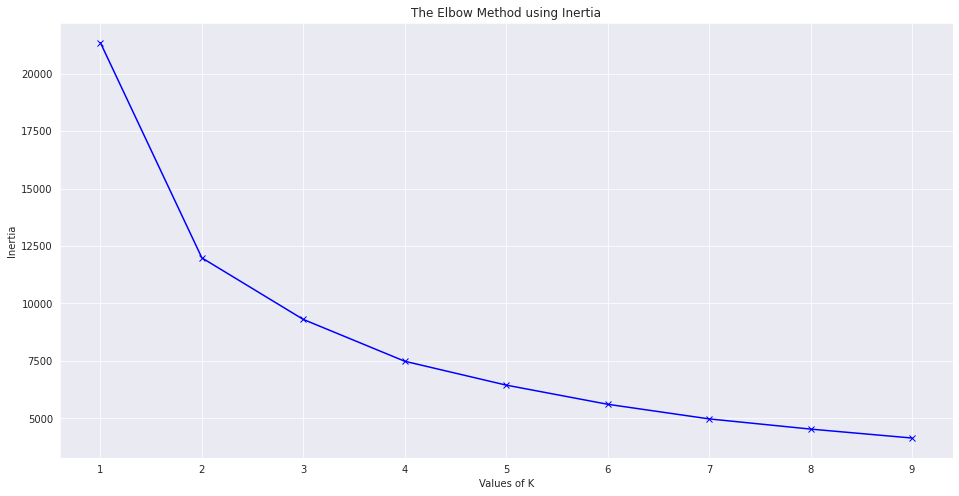

In [91]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

**Silhouette Analysis**

In [92]:
matrix = log_data.values
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    

For n_clusters = 2 The average silhouette_score is : 0.38942935180220906
For n_clusters = 3 The average silhouette_score is : 0.30209639830055296
For n_clusters = 4 The average silhouette_score is : 0.31243315517056086
For n_clusters = 5 The average silhouette_score is : 0.2920339585744148
For n_clusters = 6 The average silhouette_score is : 0.29787172439463877
For n_clusters = 7 The average silhouette_score is : 0.29426062750313225
For n_clusters = 8 The average silhouette_score is : 0.2889174056558061
For n_clusters = 9 The average silhouette_score is : 0.2904564022882666


The **best silhouette score** obtained is when there are **2 clusters**.
The **best elbow method score** obtained is when there are **3 clusters**.

In [106]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, n_init=30)
clusters = kmeans.fit(matrix)

# save the model to disk
filename = 'finalized_model_kmeans.sav'
pickle.dump(kmeans, open(filename, 'wb'))

clusters_customers = kmeans.predict(matrix)


### Visualize the Clusters

Text(0, 0.5, 'Monetary')

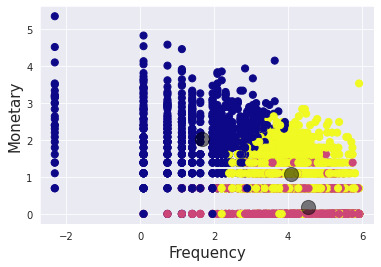

In [107]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

In [108]:
log_data['Cluster_Id'] = kmeans.labels_

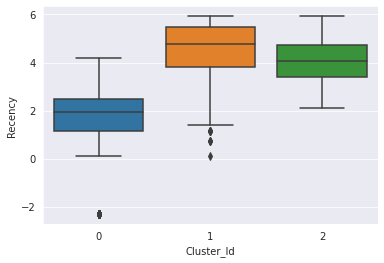

In [109]:
# Box plot to visualize Cluster Id vs Recency
# Plot cesitliligi 
sns.boxplot(x='Cluster_Id', y='Recency', data=log_data)


**Cluster 1 and Cluster 2** have high recency rate which is bad.Because of that recently they are not active so we can target these customers.
 **Cluster 0** having low so they are recent customers.They are high value customers.

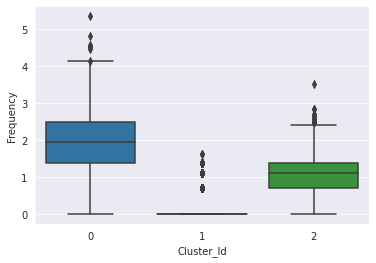

In [110]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=log_data)


**Cluster 1** have low frequency rate which is bad.These means these customers low value customers. 

**Cluster 0** highest value customers which means these customers shop a lot. Cluster 2 medium level buyers.


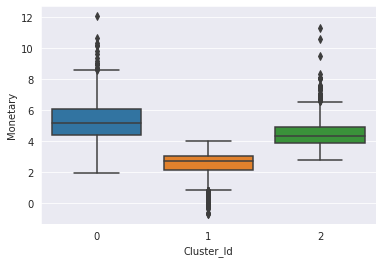

In [112]:
sns.boxplot(x='Cluster_Id', y='Monetary', data=log_data)


**Cluster 1** have low Monetary rate which is bad. 

Cluster 0 have highest Monetary (money spend)



In [135]:
# assign the label
log_data['Cluster_Id'] = kmeans.labels_
log_data.head(10)

,Recency,Frequency,Monetary,Cluster_Id
CustomerID,,,,
12346.0,5.784133,0.000000,11.253944,2
12747.0,0.741937,2.397895,6.536097,0
12748.0,-2.302585,5.342334,8.253595,0
12749.0,1.131402,1.609438,4.589549,0
12820.0,1.131402,1.386294,4.065602,0
12821.0,5.366443,0.000000,2.996732,1
12822.0,4.249923,0.693147,3.430756,1
12823.0,4.305416,1.609438,7.472842,2
12824.0,4.079231,0.000000,1.637053,1


**Conclusion**

- Cluster 0 : The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=4), frequent buyers (F=4), and spent the most (M=4)

- Cluster 1 : Second cluster can be interpreted as passer customers as their last purchase is long ago (R<=1),purchased very few (F>=2 & F < 4) and spent little (M>=4 & M < 4).Company has to come up with new strategies to make them permanent members. Low value customers
- Cluster 2 : The third cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=1), but used to purchase frequently and spent a lot.

### Conclusion

Although we didn't obtain two clearly separated clusters, we were able to build a model that can classify new customers into "low value" and "high value" groups. Generally, if a customer only transacted with us a few times, they needed to be at least in the top 50th percentile in monetary spending to be considered a "high value customer". The clusters assignments are muddled, which may be due to outliers that weren't removed.

Limitations of k-means clustering:

1. There is no assurance that it will lead to the global best solution.
2. Can't deal with different shapes(not circular) and consider one point's probability of belonging to more than one cluster.

These disadvantages of k-means show that for many datasets (especially low-dimensional datasets), it may not perform as well as you might hope.

### Recommendation

How we want to continue this analysis depends on how the business plans to use the results and the level of granularity the business stakeholders want to see in the clusters. We can also ask what range of customer behavior from high to low value customers are the stakeholders interested in exploring. From those answers, various methods of clustering can be used and applied on RFM variable or directly on the transaction data set.